# Analytic Preparation: 

In [20]:
%%capture
!pip install splunk-sdk
!pip install pandas
!pip install pandasql
import matplotlib.pyplot as plt
import pandas as pd
import pandasql
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 0)

In [21]:
import splunklib.client as client
# Create a Service instance and log in 
service = client.connect(
    host='192.168.1.68', #Input your Splunk's IP here
    port='8089',
    username="admin",
    password="Changeme1!",
    scheme='https')

# Service Creation (Investigation)
###  Author: Jonathan Johnson // Jared Atkinson

# Investigation Notes: 
During investigation, identify the following attributes: 
- `Application Name` that is requesting the service creation behavior (Clinet-Side). This Data is pulled via `Client_Side_Network_df`
- `Application Name` that is recieving the requested service creation behavior (Server-Side). This data is pulled with `Registry_Network_JOIN`
- The process that initiated the service creation. This could be the process that reached out to the RPC Server to create the Service or that parent process to that behavior as well. Example: `Powershell` calls `sc.exe` to create a service. `Powershell` is the process that should be identified. This data is pulled via `Client_Parent_Process_df`
- The methods used to create the service, this can be seen from the Zeek data in `Zeek`

# Pulling Data from Triage Notebook:

# Base Detection: 

In [22]:
%store -r Base_Condition

In [23]:
Base_Condition

,RuleName,EventType,UtcTime,ProcessGuid,ProcessId,Image,TargetObject,Source Host,Destination Host,Details,Parent Process,Iniating Process,CommandLine,Network Image,Operations,Severity
0,-,CreateKey,2020-11-02 18:47:39.477,{FA827E5A-2A19-5FA0-1D00-000000003000},1152,c:\windows\system32\svchost.exe,HKLM\System\CurrentControlSet\Services\NetBT,None,None,None,None,None,None,None,None,Low
1,-,CreateKey,2020-11-02 18:47:15.865,{63e358a4-2a03-5fa0-1a00-000000002d00},1080,C:\Windows\system32\svchost.exe,HKLM\System\CurrentControlSet\Services\NetBT,None,None,None,None,None,None,None,None,Low
2,-,CreateKey,2020-11-02 18:44:00.629,{63e358a4-2a01-5fa0-0b00-000000002d00},552,C:\Windows\system32\services.exe,HKLM\System\CurrentControlSet\Services\SO-CON,ASGARD-WRKSTN,Earth-DC.marvel.local,C:\Windows\System32\notepad.exe,sc.exe,powershell.exe,"""C:\Windows\system32\sc.exe"" \\192.168.146.15 create SO-CON binpath=C:\Windows\System32\notepad.exe",services.exe,CreateServiceW,High
3,-,CreateKey,2020-11-02 18:42:39.441,{FA827E5A-2A19-5FA0-1D00-000000003000},1152,c:\windows\system32\svchost.exe,HKLM\System\CurrentControlSet\Services\NetBT,None,None,None,None,None,None,None,None,Low
4,-,CreateKey,2020-11-02 18:42:15.817,{63e358a4-2a03-5fa0-1a00-000000002d00},1080,C:\Windows\system32\svchost.exe,HKLM\System\CurrentControlSet\Services\NetBT,None,None,None,None,None,None,None,None,Low
5,-,CreateKey,2020-11-02 18:37:39.404,{FA827E5A-2A19-5FA0-1D00-000000003000},1152,c:\windows\system32\svchost.exe,HKLM\System\CurrentControlSet\Services\NetBT,None,None,None,None,None,None,None,None,Low
6,-,CreateKey,2020-11-02 18:37:15.754,{63e358a4-2a03-5fa0-1a00-000000002d00},1080,C:\Windows\system32\svchost.exe,HKLM\System\CurrentControlSet\Services\NetBT,None,None,None,None,None,None,None,None,Low


## Graphs/Chart: 

## Initial Queries: 

In [24]:
%store -r Network_Events
%store -r Registry_JOIN
%store -r Registry_Network_JOIN

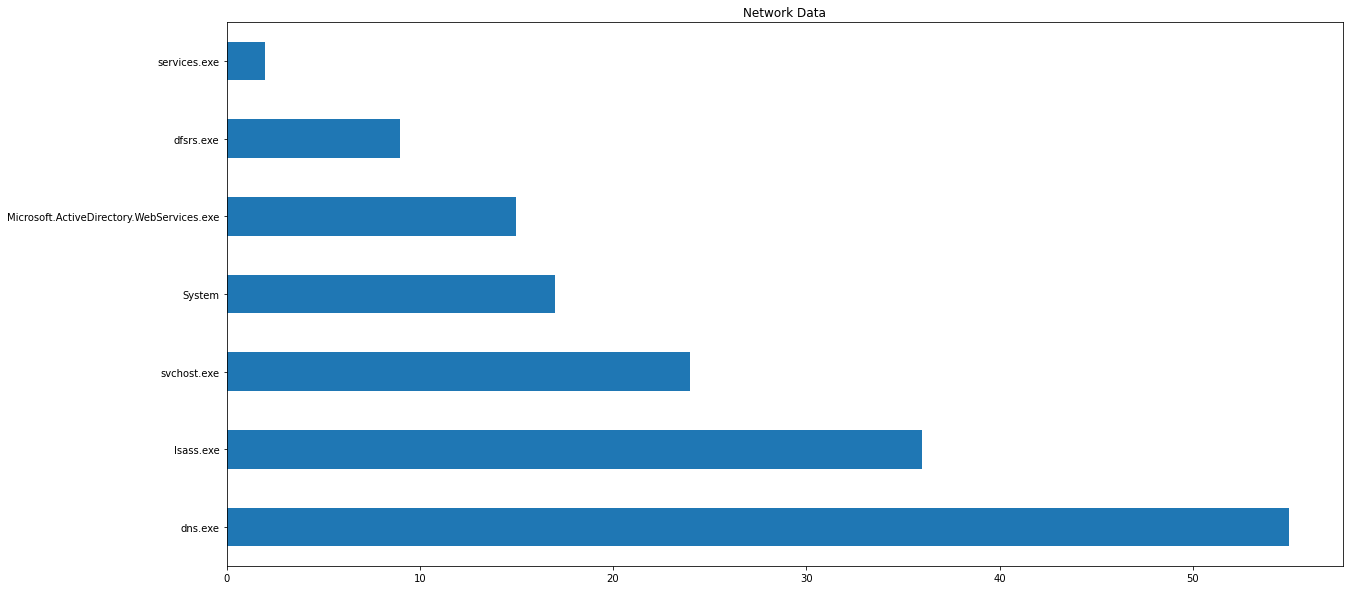

In [25]:
if len(Network_Events.index) > 0:
    Network_Events['Image'].value_counts().plot(kind='barh', figsize=(20,10), title="Network Data")
if len(Network_Events.index) == 0:
    print ("No Data")



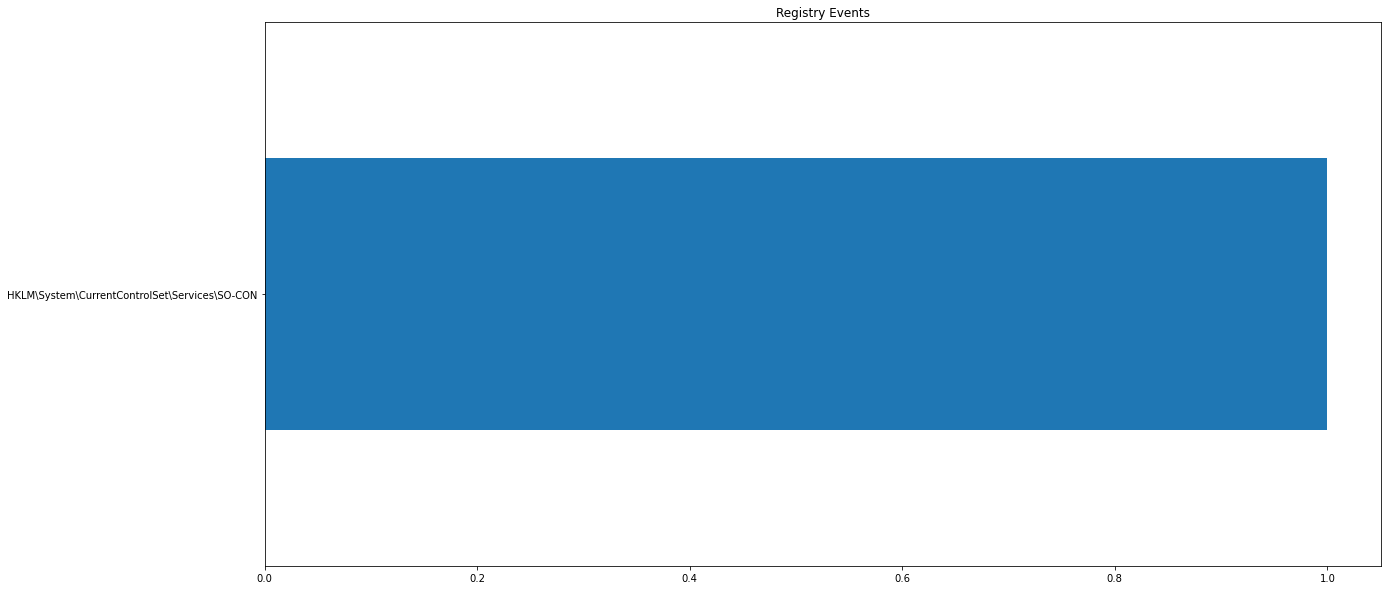

In [7]:
if len(Registry_JOIN.index) > 0:
    Registry_JOIN['TargetObject'].value_counts().plot(kind='barh', figsize=(20,10), title="Registry Events")
if len(Registry_JOIN.index) == 0:
    print ("No Data")

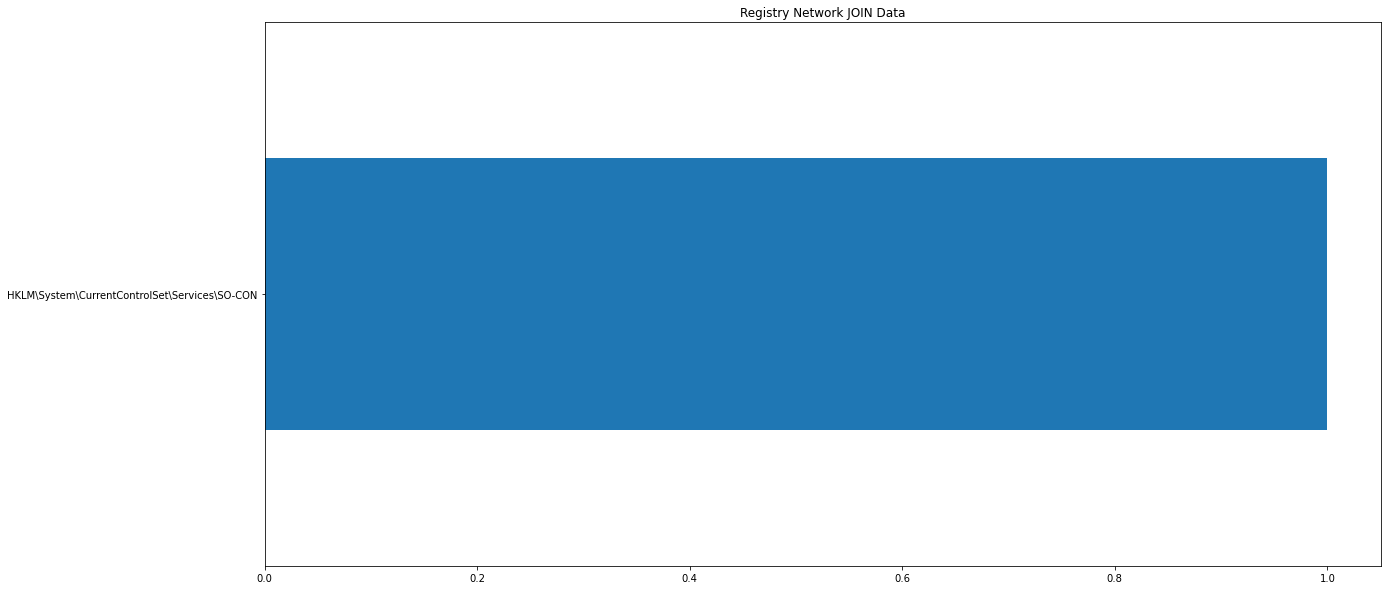

In [8]:
if len(Registry_Network_JOIN.index) > 0:
    Registry_Network_JOIN['TargetObject'].value_counts().plot(kind='barh', figsize=(20,10), title="Registry Network JOIN Data")
if len(Registry_Network_JOIN.index) == 0:
    print ("No Data")

## Advanced Queries: 

In [14]:
%store -r Zeek
%store -r Client_Side_Network_df
%store -r Client_Parent_Process_df

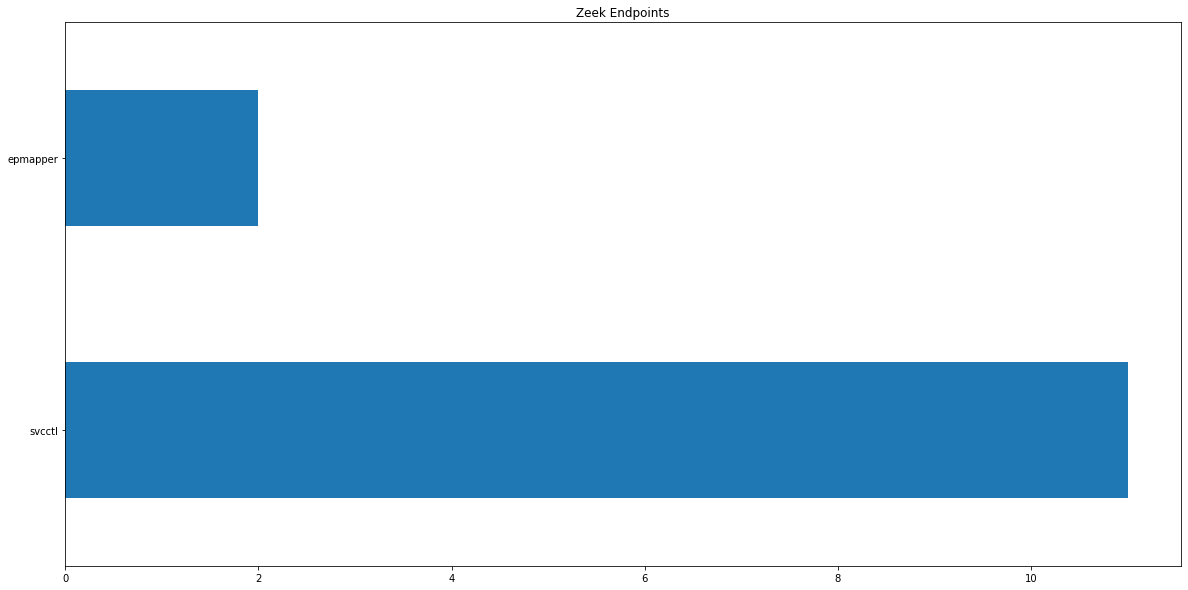

In [15]:
if len(Zeek.index) > 0:
    Zeek['endpoint'].value_counts().plot(kind='barh', figsize=(20,10), title="Zeek Endpoints")
if len(Zeek.index) == 0:
    print ("No Data")

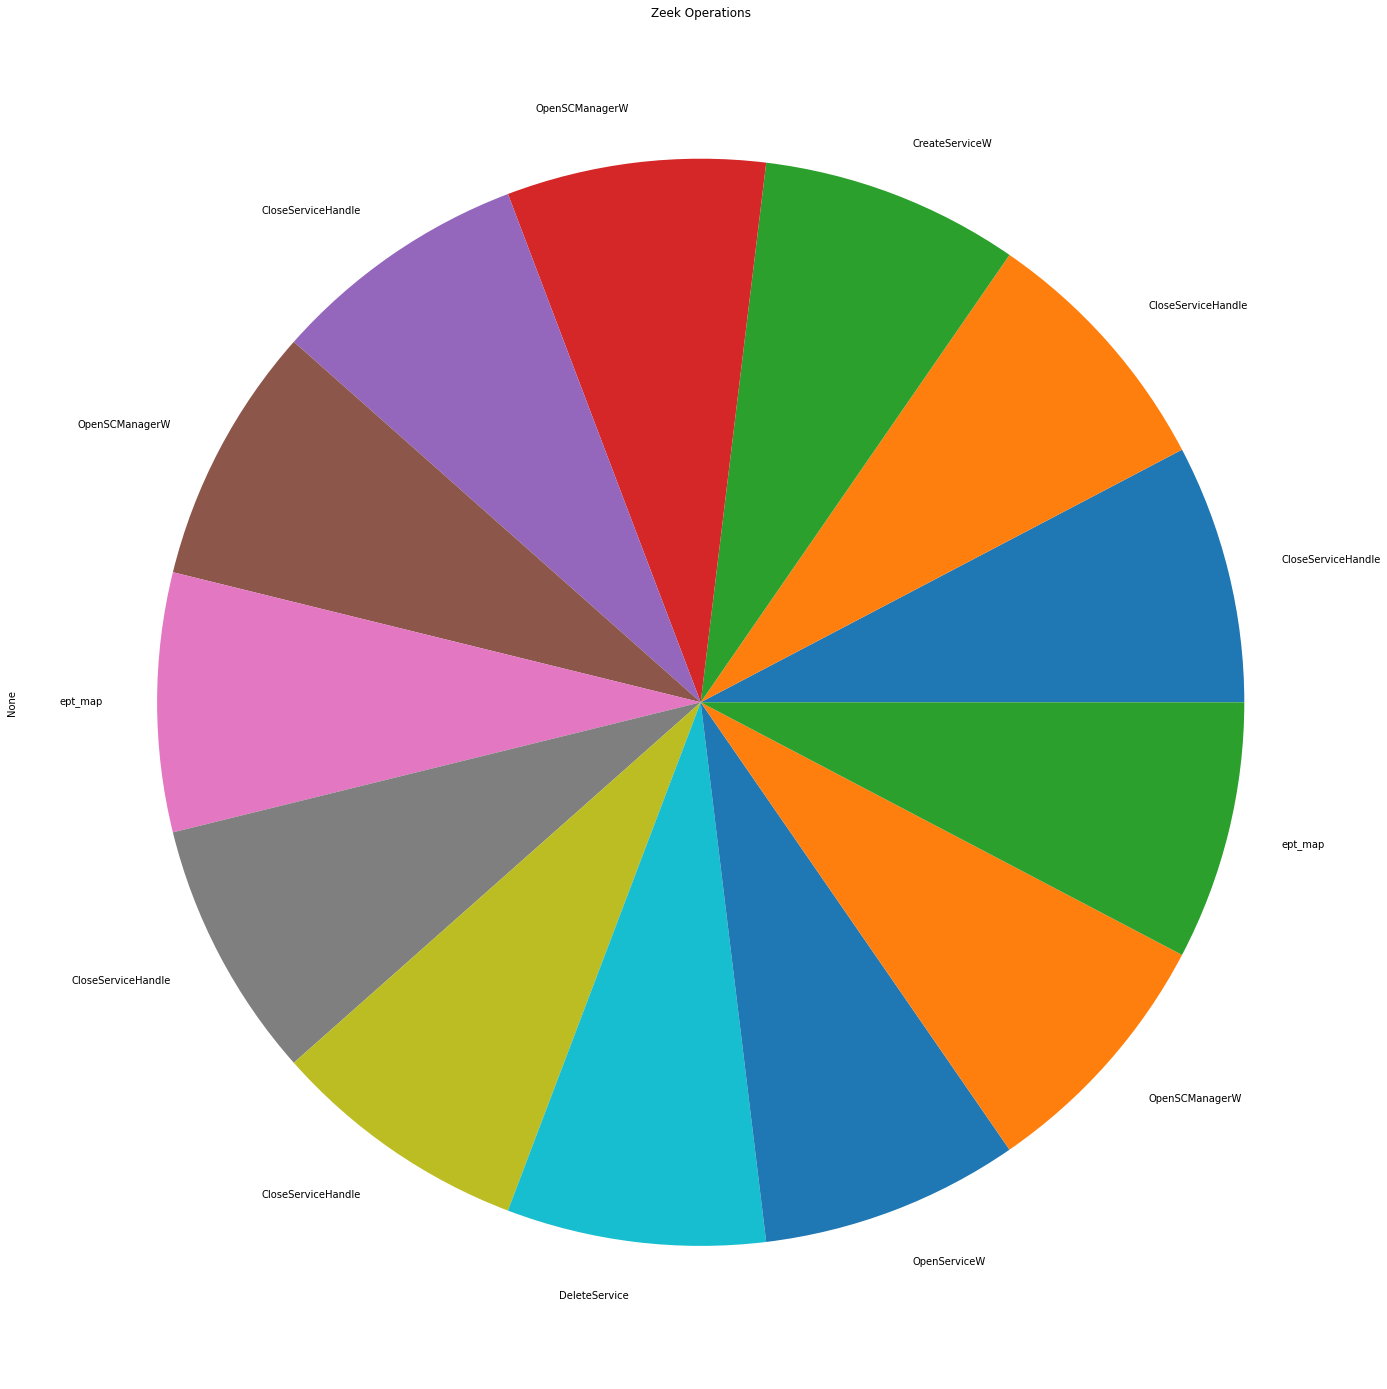

In [16]:
if len(Zeek.index) > 0:
    Zeek.value_counts().plot(kind='pie', figsize=(25,25), labels=Zeek['operation'], title="Zeek Operations")
if len(Zeek.index) == 0:
    print ("No Data")

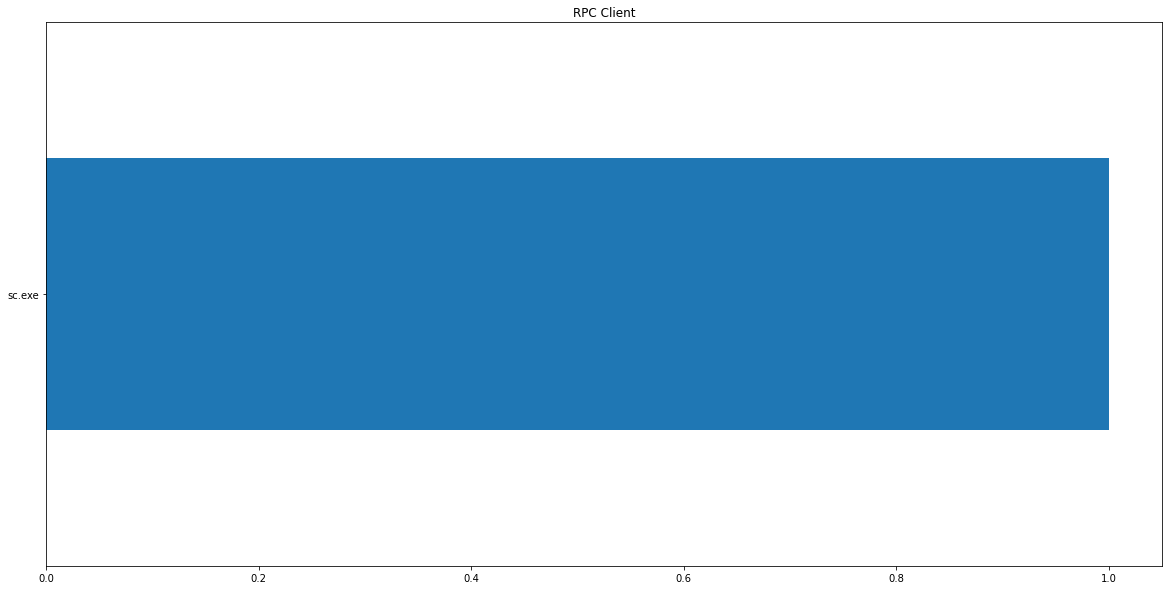

In [17]:
if len(Client_Parent_Process_df.index) > 0:
    Client_Parent_Process_df['Application Name'].value_counts().plot(kind='barh', figsize=(20,10), title="RPC Client")
if len(Client_Parent_Process_df.index) == 0:
    print ("No Data")

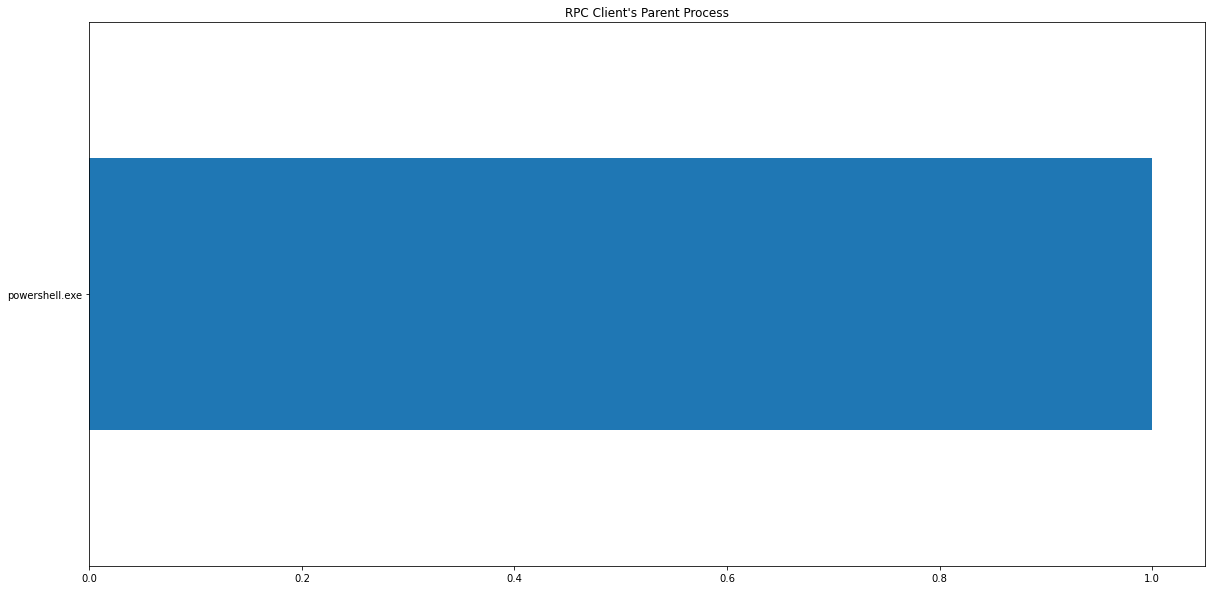

In [18]:
if len(Client_Parent_Process_df.index) > 0:
    Client_Parent_Process_df['ParentImage'].value_counts().plot(kind='barh', figsize=(20,10), title="RPC Client's Parent Process")
if len(Client_Parent_Process_df.index) == 0:
    print ("No Data")

# Remediation Notes: 
If an event is deemed malicious perform the following: 
- Remove the subkey value for the service.
- Stop the specified service on the host it was running on and remove the binary.
- Backtrack activity to identify if there was any other malicious activity performed by running the `remediation cleanse` notebook on host.
- Reset password of the user that was compromised. 